In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time
from joblib import dump

print('module imported')

module imported


In [27]:
df = pd.read_csv("/kaggle/input/anomaly-detection-dataset/anomaly_detection_dataset.csv")

In [28]:
# Add device status if not already present
if 'device_status' not in df.columns:
    df['device_status'] = (df['power_consumption'] > 0).astype(int)


In [29]:
# Add device status if not already present
if 'device_status' not in df.columns:
    df['device_status'] = (df['power_consumption'] > 0).astype(int)

In [30]:
# Power-to-occupancy mismatch
df['occupancy_mismatch'] = ((df['occupancy'] == 0) & (df['power_consumption'] > 0)).astype(int)

# Temp-to-status mismatch (e.g., AC off in high temp)
df['high_temp'] = (df['temperature'] > 30).astype(int)
df['ac_should_be_on'] = ((df['device_type'] == 'AC') & (df['high_temp'] == 1)).astype(int)
df['ac_mismatch'] = ((df['ac_should_be_on'] == 1) & (df['device_status'] == 0)).astype(int)

# Rolling average deviation
df['rolling_avg_power'] = df.groupby('device_id')['power_consumption'].transform(lambda x: x.rolling(3, min_periods=1).mean())
df['power_spike'] = ((df['power_consumption'] > 1.5 * df['rolling_avg_power']) & (df['power_consumption'] > 0)).astype(int)


In [31]:
print("🔹 Dataset Shape:", df.shape)
print("\n🔹 Column Types:")
print(df.dtypes)

print("\n🔹 Missing Values:")
print(df.isnull().sum())

print("\n🔹 column count:")
print(df.nunique())

print("\n🔹 Summary Stats:")
print(df.describe())

🔹 Dataset Shape: (12534, 19)

🔹 Column Types:
device_id                object
device_type              object
room_id                  object
power_consumption       float64
occupancy                 int64
temperature             float64
humidity                float64
hour                      int64
day_of_week              object
is_weekend                int64
rolling_avg_power_3h    float64
power_z_score           float64
device_status             int64
occupancy_mismatch        int64
high_temp                 int64
ac_should_be_on           int64
ac_mismatch               int64
rolling_avg_power       float64
power_spike               int64
dtype: object

🔹 Missing Values:
device_id               0
device_type             0
room_id                 0
power_consumption       0
occupancy               0
temperature             0
humidity                0
hour                    0
day_of_week             0
is_weekend              0
rolling_avg_power_3h    0
power_z_score           0
d

In [7]:
print(df.head(20))

    device_id device_type room_id  power_consumption  occupancy  temperature  \
0   device_84          AC  room_2               0.00          3        17.65   
1   device_28          TV  room_2               0.00          3        17.65   
2   device_97          AC  room_3               0.00          2        11.65   
3    device_6          TV  room_3               0.00          4        11.22   
4   device_54      Heater  room_3               0.00          5         7.12   
5   device_74          AC  room_0               0.00          0         5.41   
6   device_90       Light  room_0               0.00          0         5.41   
7   device_90       Light  room_0               0.00          3         6.47   
8   device_90       Light  room_0               0.00          3         7.11   
9   device_60      Fridge  room_3             149.39          3        19.66   
10  device_97          AC  room_3               0.00          5        19.66   
11  device_97          AC  room_3       

In [32]:
device_freq = df['device_id'].value_counts(normalize=True)
df['device_id_freq'] = df['device_id'].map(device_freq)
print(df.nunique())
print(df.head())

device_id                100
device_type                6
room_id                    5
power_consumption       2357
occupancy                  6
temperature             3221
humidity                4064
hour                      24
day_of_week                7
is_weekend                 2
rolling_avg_power_3h    4615
power_z_score           2630
device_status              2
occupancy_mismatch         2
high_temp                  2
ac_should_be_on            2
ac_mismatch                2
rolling_avg_power       4628
power_spike                2
device_id_freq            52
dtype: int64
   device_id device_type room_id  power_consumption  occupancy  temperature  \
0  device_84          AC  room_2                0.0          3        17.65   
1  device_28          TV  room_2                0.0          3        17.65   
2  device_97          AC  room_3                0.0          2        11.65   
3   device_6          TV  room_3                0.0          4        11.22   
4  device_54

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


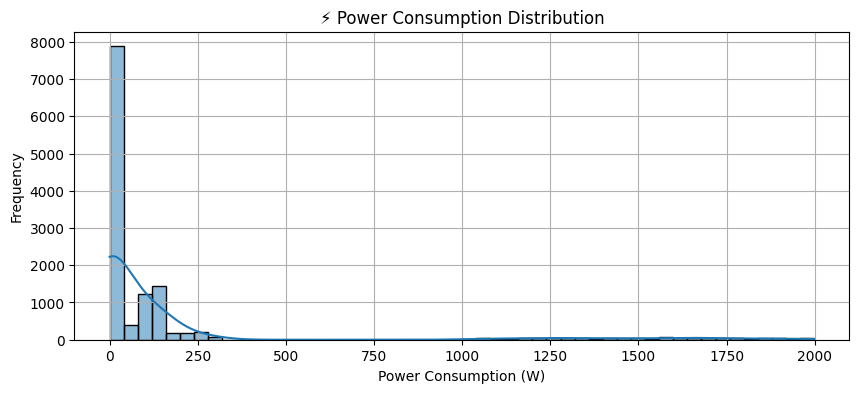

In [9]:
plt.figure(figsize=(10, 4))
sns.histplot(df['power_consumption'], bins=50, kde=True)
plt.title("⚡ Power Consumption Distribution")
plt.xlabel("Power Consumption (W)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


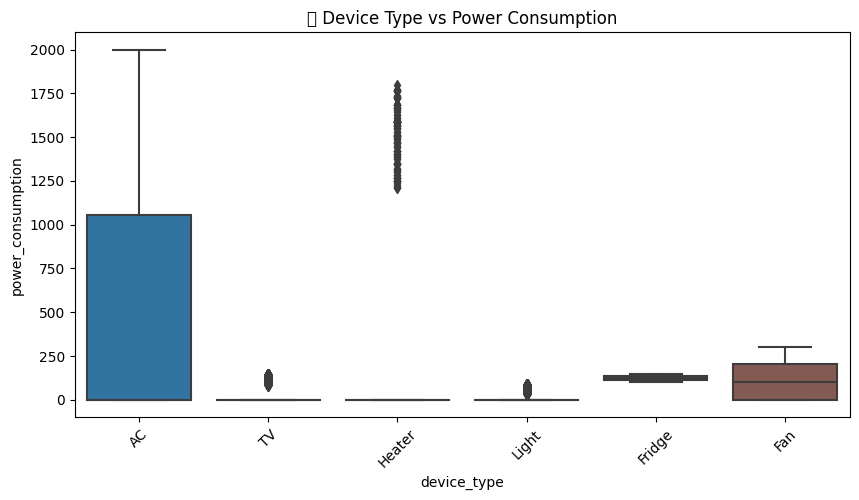

In [10]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='device_type', y='power_consumption')
plt.title("📦 Device Type vs Power Consumption")
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


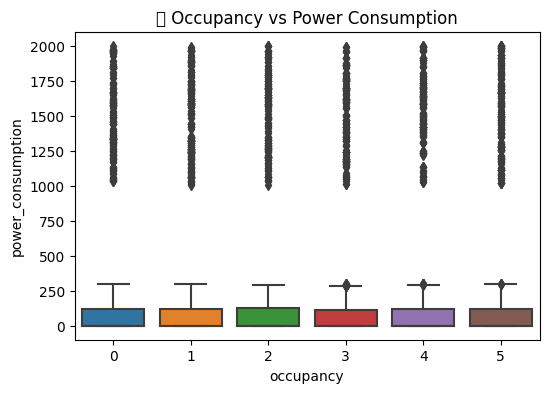

In [11]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='occupancy', y='power_consumption', data=df)
plt.title("🏠 Occupancy vs Power Consumption")
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


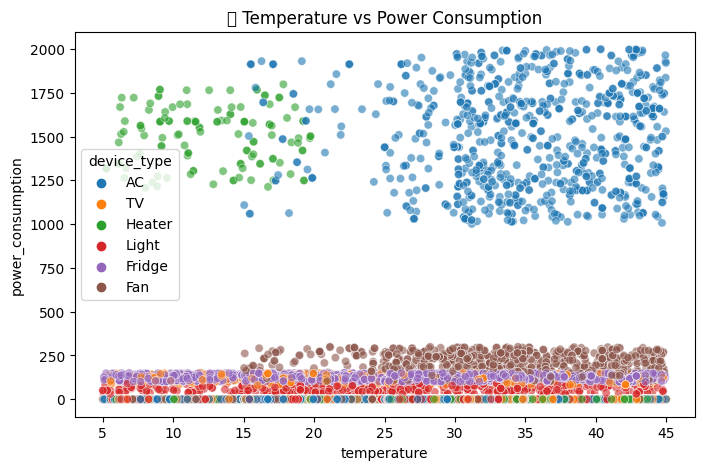

In [12]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='temperature', y='power_consumption', hue='device_type', alpha=0.6)
plt.title("🌡️ Temperature vs Power Consumption")
plt.show()

/tmp/ipykernel_31/2469840348.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='hour', y='power_consumption', estimator='mean', ci=None)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


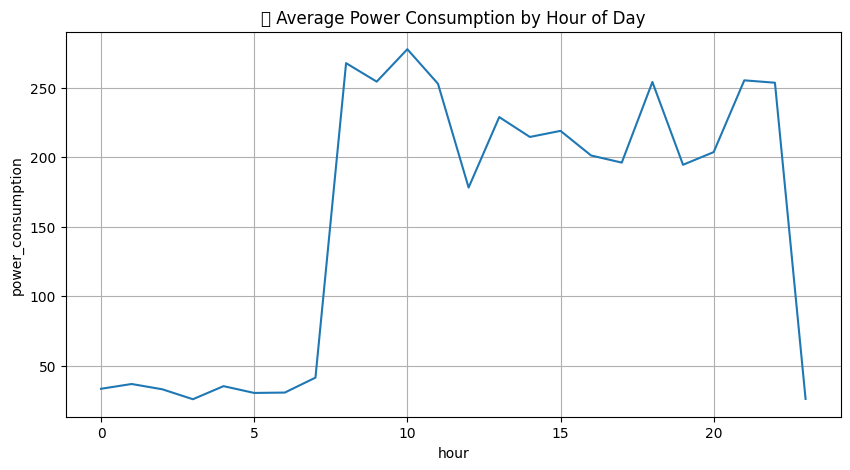

In [13]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='hour', y='power_consumption', estimator='mean', ci=None)
plt.title("⏰ Average Power Consumption by Hour of Day")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


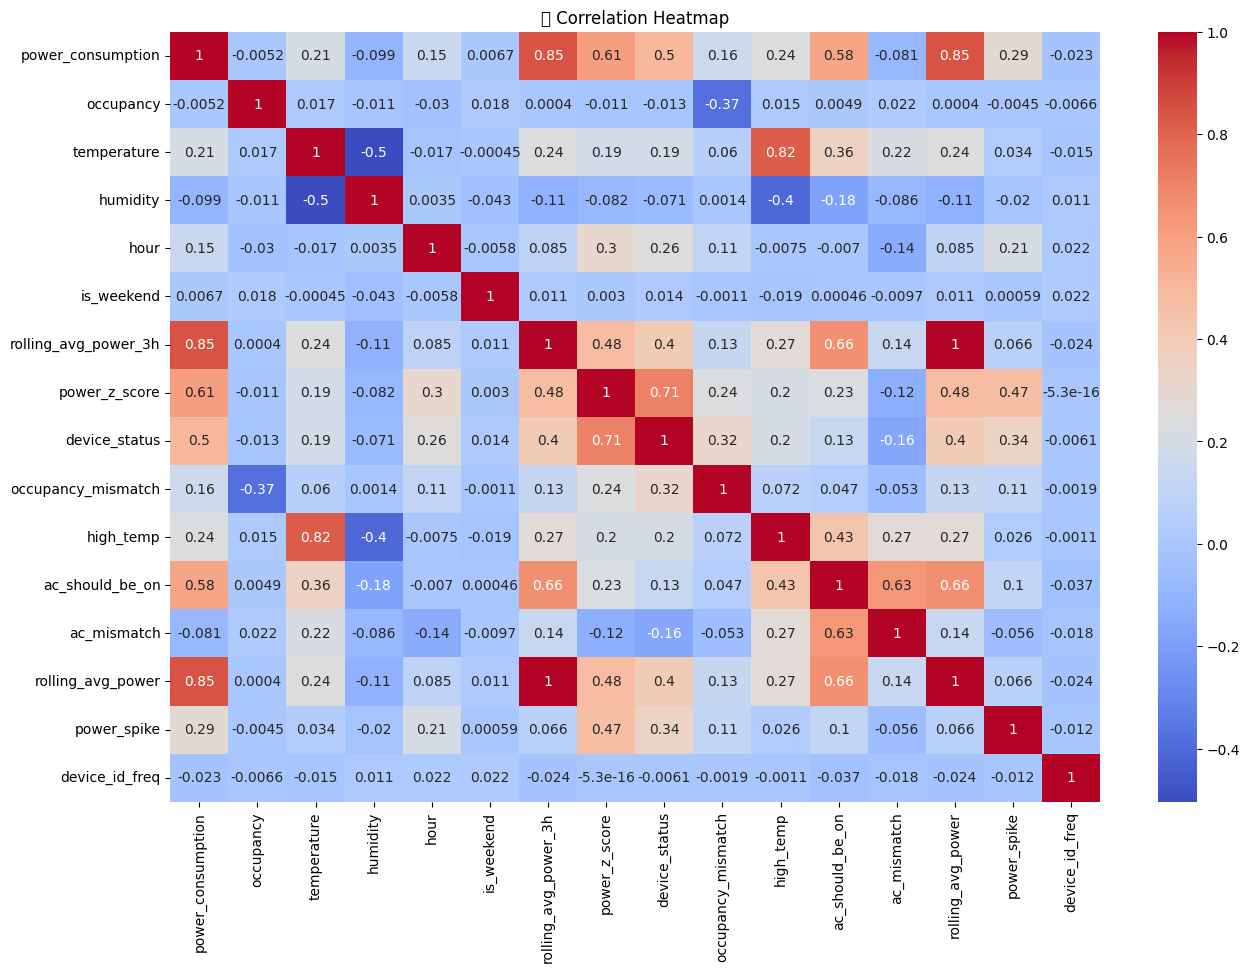

In [14]:
# ---------------- Correlation Heatmap ----------------
plt.figure(figsize=(15, 10))
numeric_cols = df.select_dtypes(include='number')
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title("🔍 Correlation Heatmap")
plt.show()

In [34]:
anomaly_data=df.drop('device_id',axis =1)

In [35]:
num_cols=[cols for cols in anomaly_data.columns if anomaly_data[cols].dtypes in ['int64','float64']]
print(num_cols)

['power_consumption', 'occupancy', 'temperature', 'humidity', 'hour', 'is_weekend', 'rolling_avg_power_3h', 'power_z_score', 'device_status', 'occupancy_mismatch', 'high_temp', 'ac_should_be_on', 'ac_mismatch', 'rolling_avg_power', 'power_spike', 'device_id_freq']


In [36]:
cat_cols=[cols for cols in anomaly_data.columns if anomaly_data[cols].dtypes=='object']
print(cat_cols)

['device_type', 'room_id', 'day_of_week']


In [37]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [39]:
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('iso_forest', IsolationForest(contamination=0.01, random_state=42))
])

In [40]:
model.fit(anomaly_data)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['power_consumption',
                                                   'occupancy', 'temperature',
                                                   'humidity', 'hour',
                                                   'is_weekend',
                                                   'rolling_avg_power_3h',
                                                   'power_z_score',
                                                   'device_status',
                                                   'occupancy_mismatch',
                                                   'high_temp',
                                                   'ac_should_be_on',
                                                   'ac_mismatch',
                                                   'rolling_avg_power',
                                                   'power_spike',
                                                   'device_id_freq']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['device_type', 'room_id',
                                                   'day_of_week'])])),
                ('iso_forest',
                 IsolationForest(contamination=0.01, random_state=42))])

In [22]:
print(df.iterrows())

<generator object DataFrame.iterrows at 0x7e983862f230>


In [41]:
dump(model, 'anomaly detection.joblib')

['anomaly detection.joblib']

In [21]:
print("🌐 Starting Real-Time Anomaly Detection Stream...")

for i, row in df.iterrows():
    # Simulate 0.5s delay per reading (adjust as needed)
    time.sleep(0.5)

    row_df = pd.DataFrame([row])  # convert single row to DataFrame
    prediction = model.predict(row_df)[0]
    is_anomaly = True if prediction == -1 else False

    # Print real-time status
    status = "🚨 Anomaly DETECTED" if is_anomaly else "✅ Normal"
    print(f"[{row['timestamp'] if 'timestamp' in row else 'stream'}] "
          f"Device: {row['device_id']} | Power: {row['power_consumption']} → {status}")

🌐 Starting Real-Time Anomaly Detection Stream...


TypeError: unsupported operand type(s) for %: 'generator' and 'int'

In [23]:
# Predict on full data again (if needed)
anomaly_data['anomaly'] = model.predict(anomaly_data)  # -1 = anomaly
anomaly_data['anomaly'] = anomaly_data['anomaly'].map({1: 0, -1: 1})

/tmp/ipykernel_31/1550153627.py:15: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


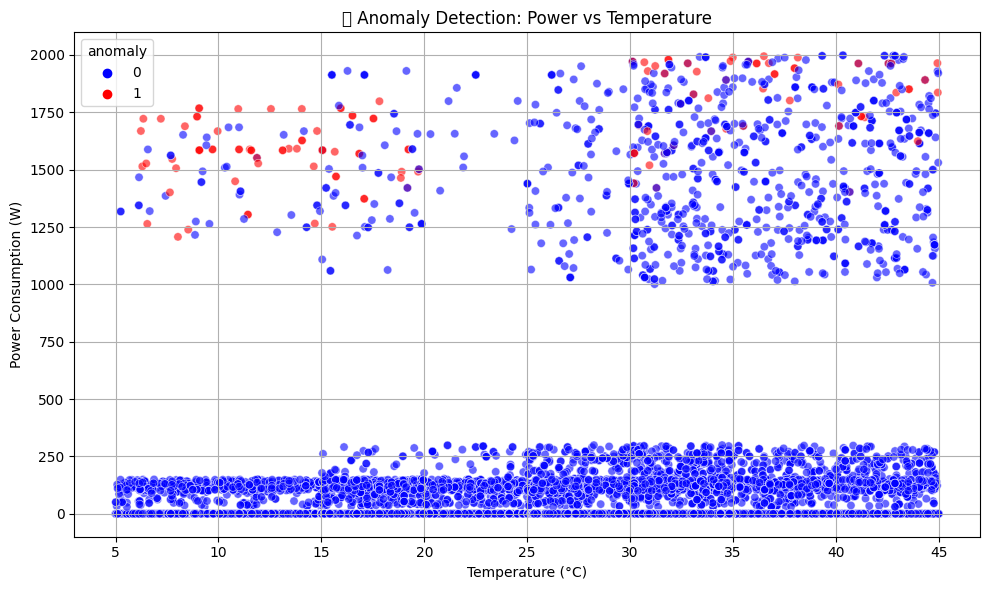

In [24]:


# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=anomaly_data, 
    x='temperature', 
    y='power_consumption', 
    hue='anomaly',
    palette={0: 'blue', 1: 'red'}, 
    alpha=0.6
)
plt.title("🔍 Anomaly Detection: Power vs Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Power Consumption (W)")
plt.grid(True)
plt.tight_layout()
plt.show()